# ONNX簡易範例

PyTorch內建的Torchvision匯入常見的模型。
請參閱:https://pytorch.org/vision/stable/models.html

只要用下列範例程式:在參數帶入
```pretrained = True```:則會下載訓練好ImageNet資料庫的預模型，帶入。
```pretrained=False```:只幫你建立好模型架構，權重是隨機產生的。

In [2]:
import torch
import torchvision.models as models
mobilenet_v2 = models.mobilenet_v2(pretrained=True)
mobilenet_v2.eval() # 記得轉模式
torch.save(mobilenet_v2,'mobilenet_v2.pth')
dummy_input = torch.randn(1, 3, 224, 224)
torch.onnx.export(mobilenet_v2, dummy_input, "mobilenet_v2.onnx")

如果只要執行ONNX runtime跑模型，需要安裝onnx和onnx runtime對應套件
- CPU版本: ```pip install onnxruntime```
- GPU版本: ```pip install onnxruntime-gpu```，若要使用GPU，需對應[cuda 版本](https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html)來安裝。

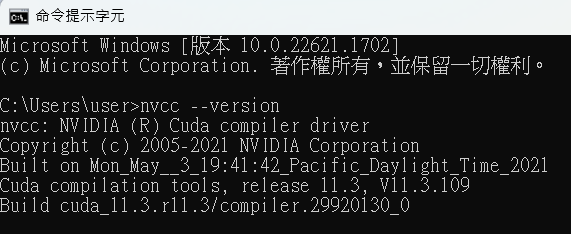

In [4]:
!pip install onnx
!pip install onnxruntime
# !pip install onnxruntime-gpu

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
scipy 1.7.1 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.3 which is incompatible.
numba 0.54.1 requires numpy<1.21,>=1.17, but you have numpy 1.24.3 which is incompatible.



  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3


In [7]:
import onnx
import onnxruntime as ort
onnxmodel_path="mobilenet_v2.onnx"
# providers = ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
providers = ['CPUExecutionProvider']
session = ort.InferenceSession(onnxmodel_path, providers=providers)
input_name = session.get_inputs()[0].name
print(input_name)

output_name = session.get_outputs()[0].name
print(output_name)


input.1
466


In [11]:
# 此指令可知道目前在用CPU還是GPU
ort.get_device() # 可以知道現在在用 CPU/GPU

'CPU'

### 使用onnxruntime的時候，輸入要是numpy array。

In [28]:
import cv2
import numpy as np
img = cv2.imread('example.png')
img = cv2.resize(img, (224,224))
img = np.array(img)/255
img = torch.FloatTensor(img)
img = img.permute(2, 0, 1)
img = img.unsqueeze(0)
img = img.numpy()

input_name = session.get_inputs()[0].name
outputs = session.run([], {input_name: img})
print("Output:{}".format(outputs[0].shape))

Output:(1, 1000)


## Netron視覺化(ONNX模型結構)
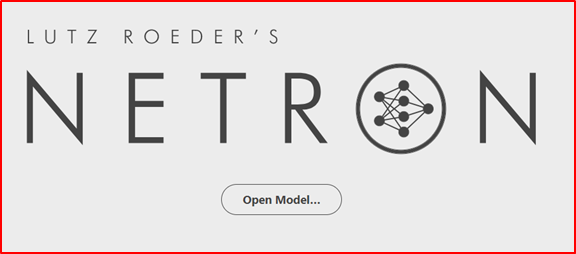

剛剛有看到輸入層是input.1，我們可以從Netron來看。

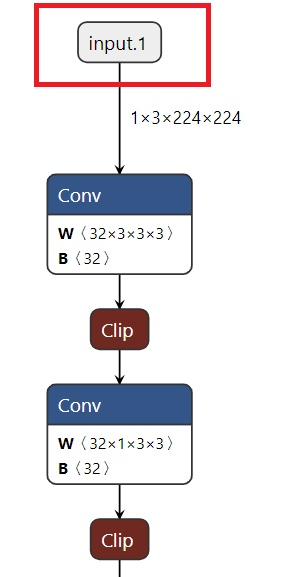

剛剛有看到輸出層是466，我們可以從Netron來看。

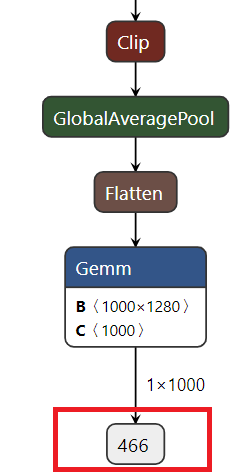

# 直接用onnx建模

output=a*x+b

In [1]:
import onnx
from onnx import helper
from onnx import TensorProto

# 1. 宣告 output, a, x, b的值
a = helper.make_tensor_value_info('a', TensorProto.FLOAT, [10, 10])
x = helper.make_tensor_value_info('x', TensorProto.FLOAT, [10, 10])
b = helper.make_tensor_value_info('b', TensorProto.FLOAT, [10, 10])
output = helper.make_tensor_value_info('output', TensorProto.FLOAT, [10, 10])

# 2. 宣告計算的Node I. 乘法(c = a*x)、II 加法(output = c+b)
# I. 乘法(c = a*x)
mul = helper.make_node('Mul', ['a', 'x'], ['c'])
# II 加法(output = c+b)
add = helper.make_node('Add', ['c', 'b'], ['output'])


# 3. 建立graph圖
graph = helper.make_graph([mul, add], 'linear_func', [a, x, b], [output])

# 4. 建立model
model = helper.make_model(graph)

# save model
onnx.checker.check_model(model)
# 一個不符合標準的ONNX 模型可能無法被推理引擎正確辨識。 ONNX 提供了一個APIonnx.checker.check_model來判斷一個ONNX 模型是否符合標準。
print(model)
onnx.save(model, 'linear_func.onnx')

ir_version: 10
opset_import {
  version: 21
}
graph {
  node {
    input: "a"
    input: "x"
    output: "c"
    op_type: "Mul"
  }
  node {
    input: "c"
    input: "b"
    output: "output"
    op_type: "Add"
  }
  name: "linear_func"
  input {
    name: "a"
    type {
      tensor_type {
        elem_type: 1
        shape {
          dim {
            dim_value: 10
          }
          dim {
            dim_value: 10
          }
        }
      }
    }
  }
  input {
    name: "x"
    type {
      tensor_type {
        elem_type: 1
        shape {
          dim {
            dim_value: 10
          }
          dim {
            dim_value: 10
          }
        }
      }
    }
  }
  input {
    name: "b"
    type {
      tensor_type {
        elem_type: 1
        shape {
          dim {
            dim_value: 10
          }
          dim {
            dim_value: 10
          }
        }
      }
    }
  }
  output {
    name: "output"
    type {
      tensor_type {
        elem_type:

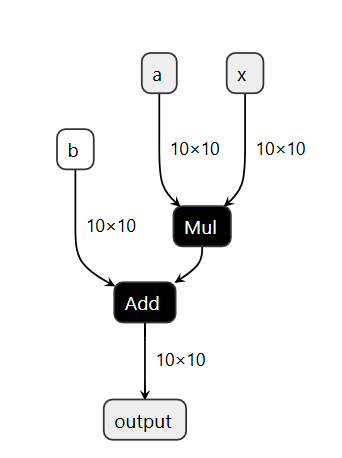

In [13]:
import onnxruntime
import numpy as np

sess = onnxruntime.InferenceSession('linear_func.onnx')
a = np.random.rand(10, 10).astype(np.float32)
b = np.random.rand(10, 10).astype(np.float32)
x = np.random.rand(10, 10).astype(np.float32)
output = sess.run(['output'], {'a': a, 'b': b, 'x': x})[0]

print(output)


[[0.72665954 1.2080209  1.6536262  0.56213534 1.1757063  0.48674262
  0.27480367 0.9650606  0.1906046  1.1810005 ]
 [1.1322411  0.44590214 0.40389064 0.9974686  0.7397236  1.6439433
  0.7342112  0.23845297 0.628163   0.85363907]
 [0.8701027  0.6034029  0.47776002 0.3648389  0.6679784  0.5801948
  1.0744103  0.73353314 1.2359462  0.66662383]
 [0.44434696 0.2434499  1.5238273  0.7448957  1.0053196  0.64991593
  0.59597564 0.7678862  0.962952   1.1761376 ]
 [0.71085244 0.2721857  0.715992   0.29511014 1.0837615  0.30789024
  1.7264054  1.2654026  0.8083334  1.7706344 ]
 [0.6734643  0.5563929  1.1624866  1.117421   0.44455743 0.8259253
  0.6975724  1.2296561  0.80547714 0.88241166]
 [0.56259507 0.7906481  1.5059385  0.6990964  1.5343878  0.7582343
  0.684937   0.43964168 1.0946195  1.5431768 ]
 [0.835611   0.9563641  1.4561408  0.49564546 0.34782273 0.67414564
  1.4557352  0.54507065 1.3659567  1.0743892 ]
 [0.94098413 1.1080568  0.29613212 1.4420434  0.864318   0.6586108
  0.7351892  0.36

In [14]:
import onnx
from onnx import helper
from onnx import TensorProto

# 1. 宣告 output, a, x, b的值
a = helper.make_tensor_value_info('a', TensorProto.FLOAT, [1])
x = helper.make_tensor_value_info('x', TensorProto.FLOAT, [1])
b = helper.make_tensor_value_info('b', TensorProto.FLOAT, [1])
output = helper.make_tensor_value_info('output', TensorProto.FLOAT, [1])

# 2. 宣告計算的Node I. 乘法(c = a*x)、II 加法(output = c+b)
# I. 乘法(c = a*x)
mul = helper.make_node('Mul', ['a', 'x'], ['c'])
# II 加法(output = c+b)
add = helper.make_node('Add', ['c', 'b'], ['output'])


# 3. 建立graph圖
graph = helper.make_graph([mul, add], 'linear_func', [a, x, b], [output])

# 4. 建立model
model = helper.make_model(graph)

# save model
onnx.checker.check_model(model)
onnx.save(model, 'linear_func_simple.onnx')

sess = onnxruntime.InferenceSession('linear_func_simple.onnx')

a = np.array([10]).astype(np.float32)
x = np.array([2]).astype(np.float32)
b = np.array([5]).astype(np.float32)

output = sess.run(['output'], {'a': a, 'b': b, 'x': x})[0]

print(output)


[25.]


# 調試ONNX 模型
在實際部署中，如果用深度學習框架導出的ONNX 模型出了問題，一般要透過修改框架的程式碼來解決，而不會從ONNX 入手，我們把ONNX 模型當成一個不可修改的黑盒子看待。
事實上，onnx模型是可以稍微修改的測試看看子模組有沒有問題。

In [16]:
import torch

class Model(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.convs1 = torch.nn.Sequential(torch.nn.Conv2d(3, 3, 3),
                                          torch.nn.Conv2d(3, 3, 3))
        self.convs2 = torch.nn.Sequential(torch.nn.Conv2d(3, 3, 3),
                                          torch.nn.Conv2d(3, 3, 3))
        self.convs3 = torch.nn.Sequential(torch.nn.Conv2d(3, 3, 3),
                                          torch.nn.Conv2d(3, 3, 3))
        self.convs4 = torch.nn.Sequential(torch.nn.Conv2d(3, 3, 3),
                                          torch.nn.Conv2d(3, 3, 3),
                                          torch.nn.Conv2d(3, 3, 3))
    def forward(self, x):
        x = self.convs1(x)
        x1 = self.convs2(x)
        x2 = self.convs3(x)
        x = x1 + x2
        x = self.convs4(x)
        return x

model = Model()
input = torch.randn(1, 3, 20, 20)

torch.onnx.export(model, input, 'whole_model.onnx')

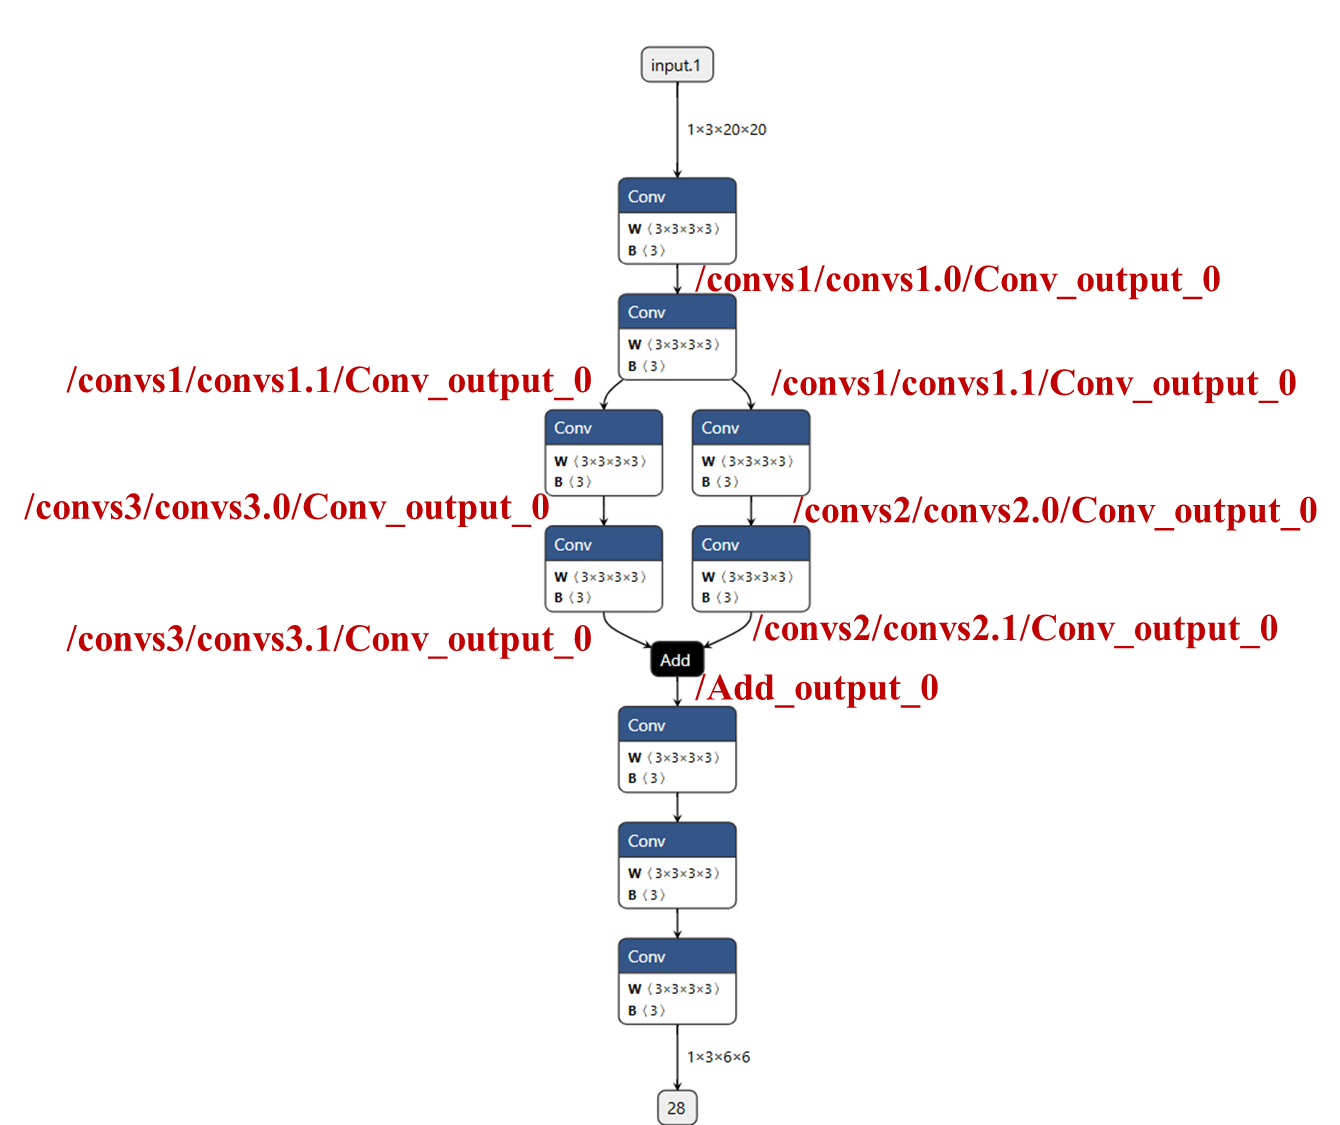

# 子模型擷取

In [19]:
import onnx

onnx.utils.extract_model('whole_model.onnx', 'partial_model.onnx', 
                         ['/convs1/convs1.0/Conv_output_0'], 
                         ['/Add_output_0'])

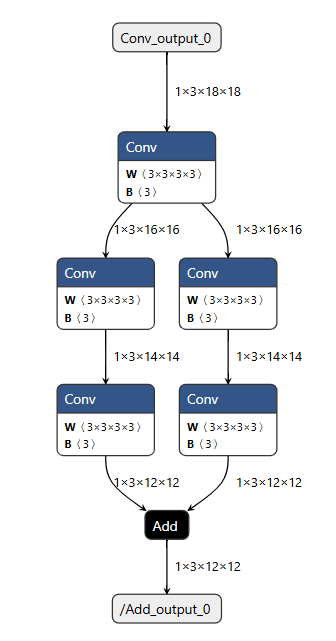

# 添加額外輸出

In [20]:
onnx.utils.extract_model('whole_model.onnx', 'submodel_1.onnx', 
                        ['/convs1/convs1.0/Conv_output_0'], 
                         ['28',
                          '/convs2/convs2.1/Conv_output_0'])


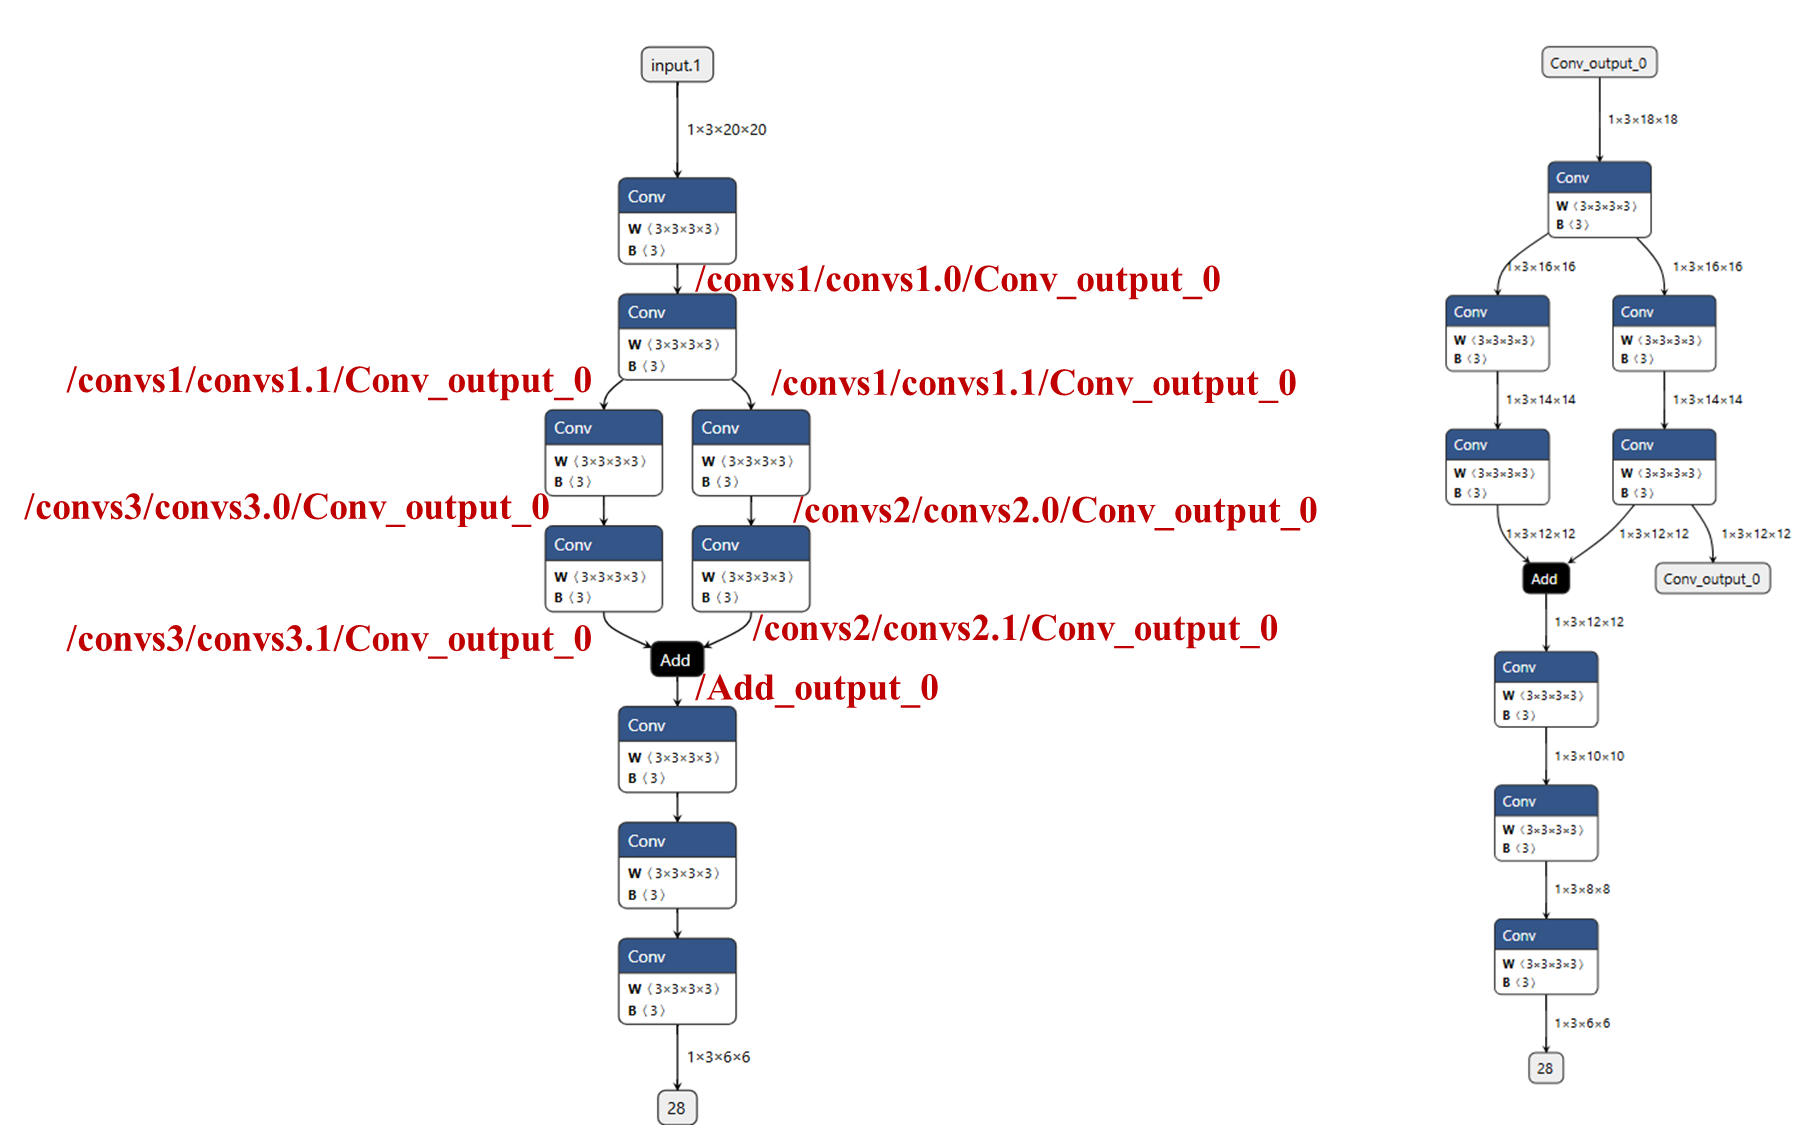

In [22]:
onnx.utils.extract_model('whole_model.onnx', 'submodel_2.onnx', 
                        ['/convs1/convs1.0/Conv_output_0'], 
                         ['28',
                          '/convs2/convs2.1/Conv_output_0',
                          '/convs3/convs3.1/Conv_output_0',
                         '/Add_output_0'])

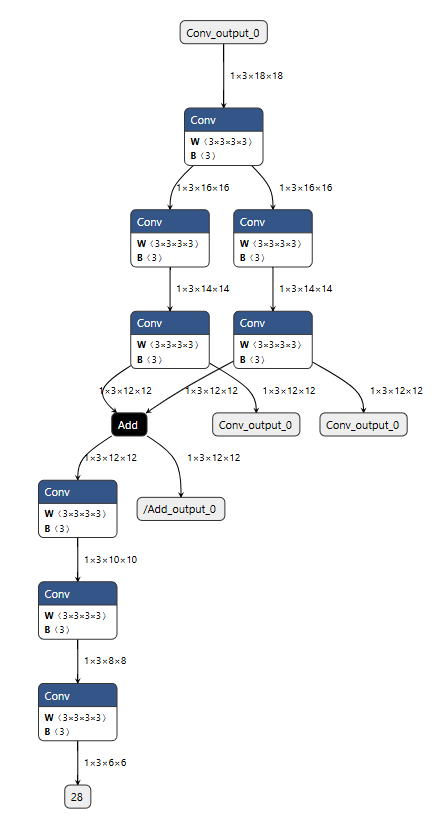

# 新增冗餘輸入
多添加了一個輸入input.1，那麼提取出的子模型會有一個冗餘的輸入input.1，如下面的程式碼所示：

In [23]:
onnx.utils.extract_model('whole_model.onnx', 'submodel_3.onnx', 
                        ['/convs1/convs1.0/Conv_output_0', 'input.1'], 
                         ['28'])

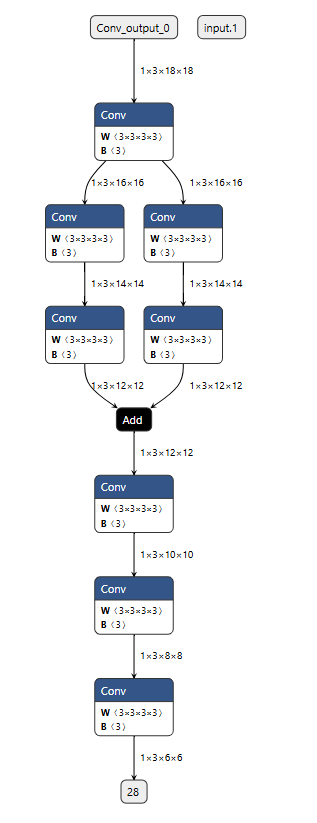


# 小結論
以上介紹onnx模型的操控，但在實際上我們通常會用PyTorch 等框架導出ONNX 模型。<br>
1. 一旦PyTorh (model定義)模型改變，ONNX 模型的邊序號也會，這樣每次提取同樣的子模組時都要重新去ONNX模型裡查序號，如此繁瑣的調試方法是不會在實務上採用的。
2. pytorch程式碼(model定義)和ONNX節點本身也很難能對起來，實際上在用的模型結構非常複雜，幾乎無法去了解每個ONNX的節點在哪行程式上定義。
   
通常我們會用到大概就只有額外輸出。其介紹。